In [1]:
# this is copied from tile.c and made a Python list
from nle.tiles import GlyphMapper
gm = GlyphMapper()

In [26]:
import IPython.display
import PIL.Image

def display(x):
    IPython.display.display(PIL.Image.fromarray(x))
    
def save(x, name):
    t = PIL.Image.fromarray(x)
    t.save(f"/Users/samvelyan/workspace/{name}.png")
    
display(gm.glyph_id_to_rgb(270)) # oracle
display(gm.glyph_id_to_rgb(1)) # killer bee 

In [500]:
# More reliable test
# Creating custom MiniHack task with many objects

from nle.minihack import MiniHackSkill, LevelGenerator, MiniHack

class MiniHackGUITest(MiniHackSkill):
    """Environment for "eat" task."""

    def __init__(self, *args, obs_crop_h=5, obs_crop_w=5, **kwargs):
        lvl_gen = LevelGenerator(w=5, h=5, lit=True)
        lvl_gen.add_stair_up((2, 2))

        lvl_gen.add_object("apple", "%", place=(0, 0))
        lvl_gen.add_object("pear", "%", place=(0, 1))
        lvl_gen.add_object("dagger", ")", place=(0, 2))
        lvl_gen.add_object("robe", "[", place=(0, 3))
        lvl_gen.add_object("boulder", "`", place=(0, 4))

        lvl_gen.add_terrain((1, 0), "W")  # water
        lvl_gen.add_terrain((1, 1), "L")  # lava
        lvl_gen.add_terrain((1, 2), "T")  # tree
        lvl_gen.add_terrain((1, 3), "{")  # fountain
        lvl_gen.add_terrain((1, 4), "F")  # iron bars

        lvl_gen.add_terrain((4, 0), "|")
        lvl_gen.add_terrain((4, 1), "|")
        lvl_gen.add_terrain((4, 2), "|")
        lvl_gen.add_terrain((4, 3), "|")
        lvl_gen.add_terrain((4, 4), "|")
        lvl_gen.add_door("open", place=(4, 1))
        lvl_gen.add_door("closed", place=(4, 3))

        lvl_gen.add_monster("killer bee", place=(3, 0))
        lvl_gen.add_monster("oracle", place=(3, 1))
        lvl_gen.add_monster("famine", place=(3, 2))
        lvl_gen.add_monster("giant ant", place=(3, 3))
        lvl_gen.add_monster("black dragon", place=(3, 4))

        des_file = lvl_gen.get_des()
        print(des_file)

        kwargs["observation_keys"] = (
            "glyphs_crop",
            "screen_descriptions_crop",
            "pixel_crop",
            "pixel",
            "inv_strs",
        )

        super().__init__(*args, des_file=des_file, **kwargs)


In [574]:
class MiniHackScratch(MiniHackSkill):
    def __init__(self, *args, **kwargs):
        des_file = """
MAZE: "mylevel", ' '
FLAGS:hardfloor, premapped
MESSAGE: "Welcome to MiniHack!"
INIT_MAP: solidfill,' '
GEOMETRY:center,center
MAP
..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
ENDMAP
REGION:(0,0,10,10),lit,"ordinary"
$rivers = TERRAIN:{'L','W','I'}
SHUFFLE:$rivers
LOOP [2] {
  TERRAIN:randline (0,0),(10,10),5,$rivers[0]
  MONSTER:random,random
}
REPLACE_TERRAIN:(0,0,10,10),'.','T',5%
STAIR:random,down
"""
        super().__init__(*args, des_file=des_file, **kwargs)

In [575]:
def vis10(x):
    x = x[7*16:17*16,34*16:44*16,:]
    display(x)
    return x
    
def vis15(x):
    m = 4
    n= 31
    x = x[m*16:(m+15)*16,n*16:(n+15)*16,:]
    display(x)
    return x

In [576]:
from nle.minihack.envs.hidenseek import MiniHackHideAndSeek
from nle.minihack.envs.corridor import *

from nle.minihack.envs.mazewalk import *
observation_keys = (
     "pixel_crop",
     "pixel",
)

class mzw(MiniHackMazeWalk):
    def __init__(self, *args, **kwargs):
        kwargs["max_episode_steps"] = kwargs.pop("max_episode_steps", 200)
        super().__init__(*args, w=11, h=11, premapped=True, **kwargs)

# for i in range(10):
#     env = MiniHackMazeWalk15x15Premapped(savedir=None,archivefile=None,observation_keys=observation_keys)
#     obs = env.reset()
#     x = vis15(obs["pixel"])
#     save(x, f"mzwk_{i}")

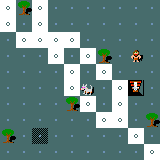

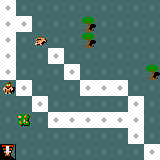

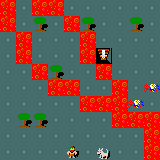

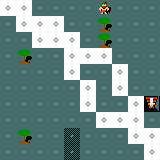

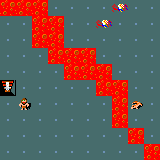

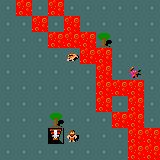

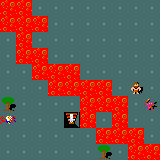

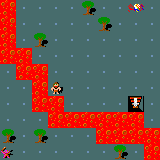

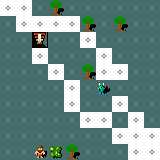

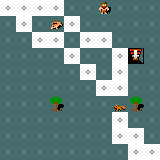

In [577]:
for i in range(10):
    env = MiniHackScratch(savedir=None,archivefile=None,observation_keys=observation_keys)
    obs = env.reset()
    x = vis10(obs["pixel"],)
    save(x, "bb_{}".format(i))

In [559]:
des_file = """
MAZE:"mylevel",' '
FLAGS: noteleport,corrmaze,premapped
GEOMETRY:right,center
# the two pools are fakes used to mark spots which need special wall fixups
# the two iron bars are eyes and spots to their left will be made diggable
MAP
-------------------------------------------------
|                   ----               ----      
|          ----     |     -----------  |         
| ------      |  ---------|.........|--P         
| F....|  -------|...........--------------      
---....|--|..................S............|----  
+...--....S..----------------|............S...|  
---....|--|..................|............|----  
| F....|  -------|...........-----S--------      
| ------      |  ---------|.........|--P         
|          ----     |     -----------  |         
|                   ----               ----      
-------------------------------------------------
ENDMAP
STAIR:levregion(01,00,15,20),levregion(15,1,70,16),up
BRANCH:levregion(01,00,15,20),levregion(15,1,70,16)
TELEPORT_REGION:levregion(01,00,15,20),levregion(15,1,70,16)
# this actually leaves the farthest right column diggable
NON_DIGGABLE:(00,00,47,12)
MAZEWALK:(00,06),west
STAIR:(44,06),down
DOOR:locked,(00,06)
IF [50%] {
   TERRAIN:(34,08),'-'
   TERRAIN:(34,04),'S'
   TERRAIN:(29,05),'|'
   TERRAIN:(29,07),'S'
}
# The fellow in residence
MONSTER:('&',"Baalzebub"),(35,06)
# Some random weapons and armor.
OBJECT:'[',random
OBJECT:'[',random
OBJECT:')',random
OBJECT:')',random
OBJECT:'*',random
OBJECT:'!',random
OBJECT:'!',random
OBJECT:'?',random
OBJECT:'?',random
OBJECT:'?',random
# Some traps.
TRAP:"spiked pit", random
TRAP:"fire", random
TRAP:"sleep gas", random
TRAP:"anti magic", random
TRAP:"fire", random
TRAP:"magic", random
TRAP:"magic", random
# Random monsters.
MONSTER:(' ',"ghost"),(37,07)
MONSTER:('&',"horned devil"),(32,05)
MONSTER:('&',"barbed devil"),(38,07)
MONSTER:'L',random
# Some Vampires for good measure
MONSTER:'V',random
MONSTER:'V',random
MONSTER:'V',random
"""


In [560]:
des_castle = """
MAZE:"mylevel",random
FLAGS: noteleport,premapped
GEOMETRY:center,center
MAP
}}}}}}}}}.............................................}}}}}}}}}
}-------}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}-------}
}|.....|-----------------------------------------------|.....|}
}|.....+...............................................+.....|}
}-------------------------------+-----------------------------}
}}}}}}|........|..........+...........|.......S.S.......|}}}}}}
.....}|........|..........|...........|.......|.|.......|}.....
.....}|........------------...........---------S---------}.....
.....}|...{....+..........+.........\.S.................+......
.....}|........------------...........---------S---------}.....
.....}|........|..........|...........|.......|.|.......|}.....
}}}}}}|........|..........+...........|.......S.S.......|}}}}}}
}-------------------------------+-----------------------------}
}|.....+...............................................+.....|}
}|.....|-----------------------------------------------|.....|}
}-------}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}-------}
}}}}}}}}}.............................................}}}}}}}}}
ENDMAP

# Random registers initialisation
$object = object: { '[',')','*','%' }
SHUFFLE: $object

$place = { (04,02),(58,02),(04,14),(58,14) }
SHUFFLE: $place

$monster = monster: { 'L','N','E','H','M','O','R','T','X','Z' }
SHUFFLE: $monster


TELEPORT_REGION:levregion(01,00,10,20),(1,1,61,15),down
TELEPORT_REGION:levregion(69,00,79,20),(1,1,61,15),up
STAIR:levregion(01,00,10,20),(0,0,62,16),up
FOUNTAIN:(10,08)
# Doors
DOOR:closed,(07,03)
DOOR:closed,(55,03)
DOOR:locked,(32,04)
DOOR:locked,(26,05)
DOOR:locked,(46,05)
DOOR:locked,(48,05)
DOOR:locked,(47,07)
DOOR:closed,(15,08)
DOOR:closed,(26,08)
DOOR:locked,(38,08)
DOOR:locked,(56,08)
DOOR:locked,(47,09)
DOOR:locked,(26,11)
DOOR:locked,(46,11)
DOOR:locked,(48,11)
DOOR:locked,(32,12)
DOOR:closed,(07,13)
DOOR:closed,(55,13)
# The drawbridge
DRAWBRIDGE:(05,08),east,closed
# Storeroom number 1
OBJECT:$object[0],(39,05)
OBJECT:$object[0],(40,05)
OBJECT:$object[0],(41,05)
OBJECT:$object[0],(42,05)
OBJECT:$object[0],(43,05)
OBJECT:$object[0],(44,05)
OBJECT:$object[0],(45,05)
OBJECT:$object[0],(39,06)
OBJECT:$object[0],(40,06)
OBJECT:$object[0],(41,06)
OBJECT:$object[0],(42,06)
OBJECT:$object[0],(43,06)
OBJECT:$object[0],(44,06)
OBJECT:$object[0],(45,06)
# Storeroom number 2
OBJECT:$object[1],(49,05)
OBJECT:$object[1],(50,05)
OBJECT:$object[1],(51,05)
OBJECT:$object[1],(52,05)
OBJECT:$object[1],(53,05)
OBJECT:$object[1],(54,05)
OBJECT:$object[1],(55,05)
OBJECT:$object[1],(49,06)
OBJECT:$object[1],(50,06)
OBJECT:$object[1],(51,06)
OBJECT:$object[1],(52,06)
OBJECT:$object[1],(53,06)
OBJECT:$object[1],(54,06)
OBJECT:$object[1],(55,06)
# Storeroom number 3
OBJECT:$object[2],(39,10)
OBJECT:$object[2],(40,10)
OBJECT:$object[2],(41,10)
OBJECT:$object[2],(42,10)
OBJECT:$object[2],(43,10)
OBJECT:$object[2],(44,10)
OBJECT:$object[2],(45,10)
OBJECT:$object[2],(39,11)
OBJECT:$object[2],(40,11)
OBJECT:$object[2],(41,11)
OBJECT:$object[2],(42,11)
OBJECT:$object[2],(43,11)
OBJECT:$object[2],(44,11)
OBJECT:$object[2],(45,11)
# Storeroom number 4
OBJECT:$object[3],(49,10)
OBJECT:$object[3],(50,10)
OBJECT:$object[3],(51,10)
OBJECT:$object[3],(52,10)
OBJECT:$object[3],(53,10)
OBJECT:$object[3],(54,10)
OBJECT:$object[3],(55,10)
OBJECT:$object[3],(49,11)
OBJECT:$object[3],(50,11)
OBJECT:$object[3],(51,11)
OBJECT:$object[3],(52,11)
OBJECT:$object[3],(53,11)
OBJECT:$object[3],(54,11)
OBJECT:$object[3],(55,11)
# THE WAND OF WISHING in 1 of the 4 towers
CONTAINER:('(',"chest"),not_trapped,$place[0] {
OBJECT:('/',"wishing")
}
# Prevent monsters from eating it.  (@'s never eat objects)
ENGRAVING:$place[0],burn,"Elbereth"
OBJECT:('?',"scare monster"),$place[0],cursed
# The treasure of the lord
OBJECT:('(',"chest"),(37,08)
# Traps
TRAP:"trap door",(40,08)
TRAP:"trap door",(44,08)
TRAP:"trap door",(48,08)
TRAP:"trap door",(52,08)
TRAP:"trap door",(55,08)
# Soldiers guarding the entry hall
MONSTER:('@',"soldier"),(08,06)
MONSTER:('@',"soldier"),(09,05)
MONSTER:('@',"soldier"),(11,05)
MONSTER:('@',"soldier"),(12,06)
MONSTER:('@',"soldier"),(08,10)
MONSTER:('@',"soldier"),(09,11)
MONSTER:('@',"soldier"),(11,11)
MONSTER:('@',"soldier"),(12,10)
MONSTER:('@',"lieutenant"),(09,08)
# Soldiers guarding the towers
MONSTER:('@',"soldier"),(03,02)
MONSTER:('@',"soldier"),(05,02)
MONSTER:('@',"soldier"),(57,02)
MONSTER:('@',"soldier"),(59,02)
MONSTER:('@',"soldier"),(03,14)
MONSTER:('@',"soldier"),(05,14)
MONSTER:('@',"soldier"),(57,14)
MONSTER:('@',"soldier"),(59,14)
# The four dragons that are guarding the storerooms
MONSTER:'D',(47,05)
MONSTER:'D',(47,06)
MONSTER:'D',(47,10)
MONSTER:'D',(47,11)
# Sea monsters in the moat
MONSTER:(';',"giant eel"),(05,07)
MONSTER:(';',"giant eel"),(05,09)
MONSTER:(';',"giant eel"),(57,07)
MONSTER:(';',"giant eel"),(57,09)
MONSTER:(';',"shark"),(05,00)
MONSTER:(';',"shark"),(05,16)
MONSTER:(';',"shark"),(57,00)
MONSTER:(';',"shark"),(57,16)
# The throne room and the court monsters
MONSTER:$monster[0],(27,05)
MONSTER:$monster[1],(30,05)
MONSTER:$monster[2],(33,05)
MONSTER:$monster[3],(36,05)
MONSTER:$monster[4],(28,06)
MONSTER:$monster[5],(31,06)
MONSTER:$monster[6],(34,06)
MONSTER:$monster[7],(37,06)
MONSTER:$monster[8],(27,07)
MONSTER:$monster[9],(30,07)
MONSTER:$monster[0],(33,07)
MONSTER:$monster[1],(36,07)
MONSTER:$monster[2],(28,08)
MONSTER:$monster[3],(31,08)
MONSTER:$monster[4],(34,08)
MONSTER:$monster[5],(27,09)
MONSTER:$monster[6],(30,09)
MONSTER:$monster[7],(33,09)
MONSTER:$monster[8],(36,09)
MONSTER:$monster[9],(28,10)
MONSTER:$monster[0],(31,10)
MONSTER:$monster[1],(34,10)
MONSTER:$monster[2],(37,10)
MONSTER:$monster[3],(27,11)
MONSTER:$monster[4],(30,11)
MONSTER:$monster[5],(33,11)
MONSTER:$monster[6],(36,11)
# MazeWalks
MAZEWALK:(00,10),west
MAZEWALK:(62,06),east
# Non diggable walls
NON_DIGGABLE:(00,00,62,16)
# Subrooms:
#   Entire castle area
REGION:(00,00,62,16),unlit,"ordinary"
#   Courtyards
REGION:(00,05,05,11),lit,"ordinary"
REGION:(57,05,62,11),lit,"ordinary"
#   Throne room
REGION:(27,05,37,11),lit,"throne",unfilled
#   Antechamber
REGION:(07,05,14,11),lit,"ordinary"
#   Storerooms
REGION:(39,05,45,06),lit,"ordinary"
REGION:(39,10,45,11),lit,"ordinary"
REGION:(49,05,55,06),lit,"ordinary"
REGION:(49,10,55,11),lit,"ordinary"
#   Corners
REGION:(02,02,06,03),lit,"ordinary"
REGION:(56,02,60,03),lit,"ordinary"
REGION:(02,13,06,14),lit,"ordinary"
REGION:(56,13,60,14),lit,"ordinary"
#   Barracks
REGION:(16,05,25,06),lit,"barracks"
REGION:(16,10,25,11),lit,"barracks"
#   Hallways
REGION:(08,03,54,03),unlit,"ordinary"
REGION:(08,13,54,13),unlit,"ordinary"
REGION:(16,08,25,08),unlit,"ordinary"
REGION:(39,08,55,08),unlit,"ordinary"
#   Storeroom alcoves
REGION:(47,05,47,06),unlit,"ordinary"
REGION:(47,10,47,11),unlit,"ordinary"
"""

In [561]:
des_Baalzebub = """
MAZE:"mylevel",' '
FLAGS: noteleport,corrmaze,premapped
GEOMETRY:right,center
# the two pools are fakes used to mark spots which need special wall fixups
# the two iron bars are eyes and spots to their left will be made diggable
MAP
-------------------------------------------------
|                   ----               ----      
|          ----     |     -----------  |         
| ------      |  ---------|.........|--P         
| F....|  -------|...........--------------      
---....|--|..................S............|----  
+...--....S..----------------|............S...|  
---....|--|..................|............|----  
| F....|  -------|...........-----S--------      
| ------      |  ---------|.........|--P         
|          ----     |     -----------  |         
|                   ----               ----      
-------------------------------------------------
ENDMAP
STAIR:levregion(01,00,15,20),levregion(15,1,70,16),up
BRANCH:levregion(01,00,15,20),levregion(15,1,70,16)
TELEPORT_REGION:levregion(01,00,15,20),levregion(15,1,70,16)
# this actually leaves the farthest right column diggable
NON_DIGGABLE:(00,00,47,12)
MAZEWALK:(00,06),west
STAIR:(44,06),down
DOOR:locked,(00,06)
IF [50%] {
   TERRAIN:(34,08),'-'
   TERRAIN:(34,04),'S'
   TERRAIN:(29,05),'|'
   TERRAIN:(29,07),'S'
}
# The fellow in residence
MONSTER:('&',"Baalzebub"),(35,06)
# Some random weapons and armor.
OBJECT:'[',random
OBJECT:'[',random
OBJECT:')',random
OBJECT:')',random
OBJECT:'*',random
OBJECT:'!',random
OBJECT:'!',random
OBJECT:'?',random
OBJECT:'?',random
OBJECT:'?',random
# Some traps.
TRAP:"spiked pit", random
TRAP:"fire", random
TRAP:"sleep gas", random
TRAP:"anti magic", random
TRAP:"fire", random
TRAP:"magic", random
TRAP:"magic", random
# Random monsters.
MONSTER:(' ',"ghost"),(37,07)
MONSTER:('&',"horned devil"),(32,05)
MONSTER:('&',"barbed devil"),(38,07)
MONSTER:'L',random
# Some Vampires for good measure
MONSTER:'V',random
MONSTER:'V',random
MONSTER:'V',random
"""

In [562]:
des_valey = """
MAZE:"mylevel",' '
FLAGS: noteleport,premapped
GEOMETRY:center,center
MAP
----------------------------------------------------------------------------
|...S.|..|.....|  |.....-|      |................|   |...............| |...|
|---|.|.--.---.|  |......--- ----..........-----.-----....---........---.-.|
|   |.|.|..| |.| --........| |.............|   |.......---| |-...........--|
|   |...S..| |.| |.......-----.......------|   |--------..---......------- |
|----------- |.| |-......| |....|...-- |...-----................----       |
|.....S....---.| |.......| |....|...|  |..............-----------          |
|.....|.|......| |.....--- |......---  |....---.......|                    |
|.....|.|------| |....--   --....-- |-------- ----....---------------      |
|.....|--......---BBB-|     |...--  |.......|    |..................|      |
|..........||........-|    --...|   |.......|    |...||.............|      |
|.....|...-||-........------....|   |.......---- |...||.............--     |
|.....|--......---...........--------..........| |.......---------...--    |
|.....| |------| |--.......--|   |..B......----- -----....| |.|  |....---  |
|.....| |......--| ------..| |----..B......|       |.--------.-- |-.....---|
|------ |........|  |.|....| |.....----BBBB---------...........---.........|
|       |........|  |...|..| |.....|  |-.............--------...........---|
|       --.....-----------.| |....-----.....----------     |.........----  |
|        |..|..B...........| |.|..........|.|              |.|........|    |
----------------------------------------------------------------------------
ENDMAP

# Make the path somewhat unpredictable
# If you get "lucky", you may have to go through all three graveyards.
IF [50%] {
   TERRAIN:line (50,8),(53,8), '-'
   TERRAIN:line (40,8),(43,8), 'B'
}
IF [50%] {
   TERRAIN:(27,12),'|'
   TERRAIN:line (27,3),(29,3), 'B'
   TERRAIN:(28,2), '-'
}
IF [50%] {
   TERRAIN:line (16,10),(16,11),'|'
   TERRAIN:line (9,13),(14,13), 'B'
}


# Dungeon Description
# The shrine to Moloch.
REGION:(01,06,05,14),lit,"temple"
# The Morgues
REGION:(19,01,24,08),unlit,"morgue",filled,irregular
REGION:(09,14,16,18),unlit,"morgue",filled,irregular
REGION:(37,09,43,14),unlit,"morgue",filled,irregular
# Stairs
STAIR:(01,01),down
# Branch location
BRANCH:(66,17,66,17),(0,0,0,0)
TELEPORT_REGION:(58,09,72,18),(0,0,0,0),down

# Secret Doors
DOOR:locked,(04,01)
DOOR:locked,(08,04)
DOOR:locked,(06,06)

# The altar of Moloch.
ALTAR:(03,10),noalign,shrine

# Non diggable walls - everywhere!
NON_DIGGABLE:(00,00,75,19)

# Objects
# **LOTS** of dead bodies (all human).
# note: no priest(esse)s or monks - maybe Moloch has a *special*
#       fate reserved for members of *those* classes.
#
OBJECT:('%',"corpse"),random,montype:"archeologist"
OBJECT:('%',"corpse"),random,montype:"archeologist"
OBJECT:('%',"corpse"),random,montype:"barbarian"
OBJECT:('%',"corpse"),random,montype:"barbarian"
OBJECT:('%',"corpse"),random,montype:"caveman"
OBJECT:('%',"corpse"),random,montype:"cavewoman"
OBJECT:('%',"corpse"),random,montype:"healer"
OBJECT:('%',"corpse"),random,montype:"healer"
OBJECT:('%',"corpse"),random,montype:"knight"
OBJECT:('%',"corpse"),random,montype:"knight"
OBJECT:('%',"corpse"),random,montype:"ranger"
OBJECT:('%',"corpse"),random,montype:"ranger"
OBJECT:('%',"corpse"),random,montype:"rogue"
OBJECT:('%',"corpse"),random,montype:"rogue"
OBJECT:('%',"corpse"),random,montype:"samurai"
OBJECT:('%',"corpse"),random,montype:"samurai"
OBJECT:('%',"corpse"),random,montype:"tourist"
OBJECT:('%',"corpse"),random,montype:"tourist"
OBJECT:('%',"corpse"),random,montype:"valkyrie"
OBJECT:('%',"corpse"),random,montype:"valkyrie"
OBJECT:('%',"corpse"),random,montype:"wizard"
OBJECT:('%',"corpse"),random,montype:"wizard"
#
# Some random weapons and armor.
#
OBJECT:'[',random
OBJECT:'[',random
OBJECT:'[',random
OBJECT:'[',random
OBJECT:')',random
OBJECT:')',random
OBJECT:')',random
OBJECT:')',random
#
# Some random loot.
#
OBJECT:('*',"ruby"),random
OBJECT:'*',random
OBJECT:'*',random
OBJECT:'!',random
OBJECT:'!',random
OBJECT:'!',random
OBJECT:'?',random
OBJECT:'?',random
OBJECT:'?',random
OBJECT:'/',random
OBJECT:'/',random
OBJECT:'=',random
OBJECT:'=',random
OBJECT:'+',random
OBJECT:'+',random
OBJECT:'(',random
OBJECT:'(',random
OBJECT:'(',random

# (Not so) Random traps.
TRAP:"spiked pit", (05,02)
TRAP:"spiked pit", (14,05)
TRAP:"sleep gas", (03,01)
TRAP:"board", (21,12)
TRAP:"board", random
TRAP:"dart", (60,01)
TRAP:"dart", (26,17)
TRAP:"anti magic", random
TRAP:"anti magic", random
TRAP:"magic", random
TRAP:"magic", random

# Random monsters.
# The ghosts.
MONSTER:(' ',"ghost"),random
MONSTER:(' ',"ghost"),random
MONSTER:(' ',"ghost"),random
MONSTER:(' ',"ghost"),random
MONSTER:(' ',"ghost"),random
MONSTER:(' ',"ghost"),random
# Add a few bats for atmosphere.
MONSTER:('B',"vampire bat"),random
MONSTER:('B',"vampire bat"),random
MONSTER:('B',"vampire bat"),random
# And a lich for good measure.
MONSTER:'L',random
# Some undead nasties for good measure
MONSTER:'V',random
MONSTER:'V',random
MONSTER:'V',random
MONSTER:'Z',random
MONSTER:'Z',random
MONSTER:'Z',random
MONSTER:'Z',random
MONSTER:'M',random
MONSTER:'M',random
MONSTER:'M',random
MONSTER:'M',random
"""

In [566]:
des_med="""
LEVEL:"mylevel"
FLAGS: noteleport,mazelevel,premapped
INIT_MAP:solidfill,' '
GEOMETRY:center,center
#
# Here the Medusa rules some slithery monsters from her 'palace', with
# a yellow dragon nesting in the backyard.
#
MAP
}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}
}}}}}}}}}}}}}}........}}}}}}}}}}}}}}}}}}}}}}}..}}}.....}}}}}}}}}}}----|}}}}}
}}}}}}..----------F-.....}}}}}}}}}}}}}}}}..---...}}}}....T.}}}}}}}....|}}}}}
}}}.....|...F......S}}}}....}}}}}}}...}}.....|}}.}}}}}}}......}}}}|......}}}
}}}.....+...|..{...|}}}}}}}}}}}}.....}}}}|...|}}}}}}}}}}}.}}}}}}}}----.}}}}}
}}......|...|......|}}}}}}}}}......}}}}}}|.......}}}}}}}}}}}}}..}}}}}...}}}}
}}|-+--F|-+--....|F|-|}}}}}....}}}....}}}-----}}.....}}}}}}}......}}}}.}}}}}
}}|...}}|...|....|}}}|}}}}}}}..}}}}}}}}}}}}}}}}}}}}....}}}}}}}}....T.}}}}}}}
}}|...}}F...+....F}}}}}}}..}}}}}}}}}}}}}}...}}}}}}}}}}}}}}}}}}}}}}....}}..}}
}}|...}}|...|....|}}}|}....}}}}}}....}}}...}}}}}...}}}}}}}}}}}}}}}}}.....}}}
}}--+--F|-+--....-F|-|....}}}}}}}}}}.T...}}}}....---}}}}}}}}}}}}}}}}}}}}}}}}
}}......|...|......|}}}}}.}}}}}}}}}....}}}}}}}.....|}}}}}}}}}.}}}}}}}}}}}}}}
}}}}....+...|..{...|.}}}}}}}}}}}}}}}}}}}}}}}}}}.|..|}}}}}}}......}}}}...}}}}
}}}}}}..|...F......|...}}}}}}}}}}..---}}}}}}}}}}--.-}}}}}....}}}}}}....}}}}}
}}}}}}}}-----S----F|....}}}}}}}}}|...|}}}}}}}}}}}}...}}}}}}...}}}}}}..}}}}}}
}}}}}}}}}..............T...}}}}}.|.......}}}}}}}}}}}}}}..}...}.}}}}....}}}}}
}}}}}}}}}}....}}}}...}...}}}}}.......|.}}}}}}}}}}}}}}.......}}}}}}}}}...}}}}
}}}}}}}}}}..}}}}}}}}}}.}}}}}}}}}}-..--.}}}}}}}}..}}}}}}..T...}}}..}}}}}}}}}}
}}}}}}}}}...}}}}}}}}}}}}}}}}}}}}}}}...}}}}}}}....}}}}}}}.}}}..}}}...}}}}}}}}
}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}.}}}}}}....}}}}}}}}}}}}}}}}}}}...}}}}}}
}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}
ENDMAP
#
$place = { (04,08),(10,04),(10,08),(10,12) }
SHUFFLE: $place
#
REGION:(00,00,74,19),lit,"ordinary"
REGION:(13,03,18,13),lit,"ordinary",unfilled
#
TELEPORT_REGION:(64,01,74,17),(0,0,0,0),down
TELEPORT_REGION:(02,02,18,13),(0,0,0,0),up
#
STAIR:(67,01,74,20),(0,0,0,0),up
STAIR:$place[0],down
#
DOOR:locked,(04,06)
DOOR:locked,(04,10)
DOOR:locked,(08,04)
DOOR:locked,(08,12)
DOOR:locked,(10,06)
DOOR:locked,(10,10)
DOOR:locked,(12,08)
#
BRANCH:levregion(27,00,79,20),(0,0,0,0)
#
NON_DIGGABLE:(01,01,22,14)
#
OBJECT:('(',"crystal ball"),(07,08)
#
CONTAINER:('`',"statue"),$place[1],uncursed,montype:"knight",3,name:"Perseus" {
  [75%]: OBJECT: ('[',"shield of reflection"),cursed,+0
  [25%]: OBJECT: ('[',"levitation boots"),+0
  [50%]: OBJECT: (')',"scimitar"),blessed,+2
  [50%]: OBJECT: ('(',"sack")
}
#
CONTAINER:('`',"statue"),random { }
CONTAINER:('`',"statue"),random { }
CONTAINER:('`',"statue"),random { }
CONTAINER:('`',"statue"),random { }
CONTAINER:('`',"statue"),random { }
CONTAINER:('`',"statue"),random { }
CONTAINER:('`',"statue"),random { }
LOOP [8] {
  OBJECT:random,random
}
#
LOOP [7] {
  TRAP:random,random
}
#
MONSTER:('@',"Medusa"),$place[0]
MONSTER:(';',"kraken"),(07,07)
#
# the nesting dragon
MONSTER:('D',"yellow dragon"), (05,04), asleep
[50%]: MONSTER: ('D',"baby yellow dragon"), (04,04), asleep
[25%]: MONSTER: ('D',"baby yellow dragon"), (04,05), asleep
OBJECT:('%',"egg"), (05,04), montype:"yellow dragon"
[50%]: OBJECT: ('%',"egg"), (05,04), montype:"yellow dragon"
[25%]: OBJECT: ('%',"egg"), (05,04), montype:"yellow dragon"
#
MONSTER:(';',"giant eel"),random
MONSTER:(';',"giant eel"),random
MONSTER:(';',"jellyfish"),random
MONSTER:(';',"jellyfish"),random
LOOP [14] {
  MONSTER:'S',random
}
LOOP [4] {
  MONSTER:('N',"black naga hatchling"), random
  MONSTER:('N',"black naga"), random
}
"""

In [570]:
des_med1="""
MAZE:"mylevel",' '
FLAGS: noteleport,premapped
GEOMETRY:center,center
MAP
}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}
}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}
}}.}}}}}..}}}}}......}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}....}}}...}}}}}
}...}}.....}}}}}....}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}...............}
}....}}}}}}}}}}....}}}..}}}}}}}}}}}.......}}}}}}}}}}}}}}}}..}}.....}}}...}}
}....}}}}}}}}.....}}}}..}}}}}}.................}}}}}}}}}}}.}}}}.....}}...}}
}....}}}}}}}}}}}}.}}}}.}}}}}}.-----------------.}}}}}}}}}}}}}}}}}.........}
}....}}}}}}}}}}}}}}}}}}.}}}...|...............S...}}}}}}}}}}}}}}}}}}}....}}
}.....}.}}....}}}}}}}}}.}}....--------+--------....}}}}}}..}}}}}}}}}}}...}}
}......}}}}..}}}}}}}}}}}}}........|.......|........}}}}}....}}}}}}}}}}}}}}}
}.....}}}}}}}}}}}}}}}}}}}}........|.......|........}}}}}...}}}}}}}}}.}}}}}}
}.....}}}}}}}}}}}}}}}}}}}}....--------+--------....}}}}}}.}.}}}}}}}}}}}}}}}
}......}}}}}}}}}}}}}}}}}}}}...S...............|...}}}}}}}}}}}}}}}}}.}}}}}}}
}.......}}}}}}}..}}}}}}}}}}}}.-----------------.}}}}}}}}}}}}}}}}}....}}}}}}
}........}}.}}....}}}}}}}}}}}}.................}}}}}..}}}}}}}}}.......}}}}}
}.......}}}}}}}......}}}}}}}}}}}}}}.......}}}}}}}}}.....}}}}}}...}}..}}}}}}
}.....}}}}}}}}}}}.....}}}}}}}}}}}}}}}}}}}}}}.}}}}}}}..}}}}}}}}}}....}}}}}}}
}}..}}}}}}}}}}}}}....}}}}}}}}}}}}}}}}}}}}}}...}}..}}}}}}}.}}.}}}}..}}}}}}}}
}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}
}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}}
ENDMAP
# Dungeon Description
# (must maintain one room definition; `unfilled' forces its room to be kept)
REGION:(00,00,74,19),lit,"ordinary"
REGION:(31,07,45,07),unlit,"ordinary"
REGION:(35,09,41,10),unlit,"ordinary",unfilled
REGION:(31,12,45,12),unlit,"ordinary"
# Teleport: down to up stairs island, up to Medusa's island
TELEPORT_REGION:(01,01,05,17),(0,0,0,0),down
TELEPORT_REGION:(26,04,50,15),(0,0,0,0),up
# Stairs
STAIR:(05,14),up
STAIR:(36,10),down
# Doors
DOOR:closed,(46,07)
DOOR:locked,(38,08)
DOOR:locked,(38,11)
DOOR:closed,(30,12)
# Branch, not allowed inside Medusa's building.
BRANCH:levregion(01,00,79,20),(30,06,46,13)
# Non diggable walls
NON_DIGGABLE:(30,06,46,13)
# Objects
CONTAINER:('`',"statue"),(36,10),uncursed,montype:"knight",3,name:"Perseus" {
  [75%]: OBJECT:('[',"shield of reflection"),cursed,+0
  [25%]: OBJECT:('[',"levitation boots"),+0
  [50%]: OBJECT:(')',"scimitar"),blessed,+2
  [50%]: OBJECT:('(',"sack")
}
# These aren't really containers, but specifying CONTAINER forces them to be
# empty, since CONTAINERs contain only what is explicitly specified.
CONTAINER:('`',"statue"),random { }
CONTAINER:('`',"statue"),random { }
CONTAINER:('`',"statue"),random { }
CONTAINER:('`',"statue"),random { }
CONTAINER:('`',"statue"),random { }
CONTAINER:('`',"statue"),random { }
CONTAINER:('`',"statue"),random { }
OBJECT:random,random
OBJECT:random,random
OBJECT:random,random
OBJECT:random,random
OBJECT:random,random
OBJECT:random,random
OBJECT:random,random
OBJECT:random,random
# Random traps
TRAP:random,random
TRAP:random,random
TRAP:random,random
TRAP:random,random
TRAP:random,random
TRAP:"board",(38,07)
TRAP:"board",(38,12)
# Random monsters
MONSTER:('@',"Medusa"),(36,10),asleep
MONSTER:(';',"giant eel"),(11,06)
MONSTER:(';',"giant eel"),(23,13)
MONSTER:(';',"giant eel"),(29,02)
MONSTER:(';',"jellyfish"),(02,02)
MONSTER:(';',"jellyfish"),(00,08)
MONSTER:(';',"jellyfish"),(04,18)
MONSTER:('T',"water troll"),(51,03)
MONSTER:('T',"water troll"),(64,11)
MONSTER:'S',(38,07)
MONSTER:'S',(38,12)
MONSTER:random,random
MONSTER:random,random
MONSTER:random,random
MONSTER:random,random
MONSTER:random,random
MONSTER:random,random
MONSTER:random,random
MONSTER:random,random
MONSTER:random,random
MONSTER:random,random
"""

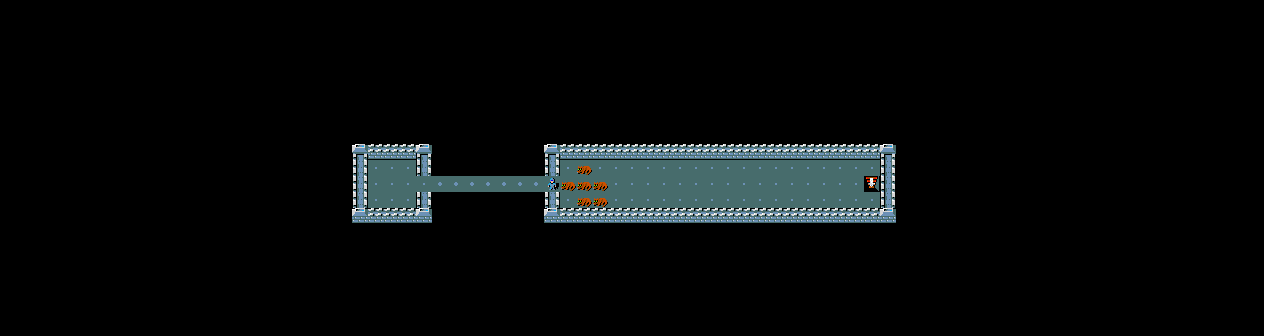

In [571]:
class MiniHackFightCorridor(MiniHackNavigation):
    def __init__(self, *args, lit=True, **kwargs):
        kwargs["character"] = "kni-hum-law-fem"  # tested on human knight
        kwargs["max_episode_steps"] = kwargs.pop("max_episode_steps", 350)

        map = """
-----       ----------------------
|...|       |....................|
|....#######.....................|
|...|       |....................|
-----       ----------------------
"""
        lvl_gen = LevelGenerator(map=map, lit=lit, flags=('premapped',))
        lvl_gen.set_start_pos((12, 2))
        lvl_gen.add_monster(name="giant rat", place=(14, 1))
        lvl_gen.add_monster(name="giant rat", place=(14, 2))
        lvl_gen.add_monster(name="giant rat", place=(14, 3))
        lvl_gen.add_monster(name="giant rat", place=(14, 1))
        lvl_gen.add_monster(name="giant rat", place=(14, 2))
        lvl_gen.add_monster(name="giant rat", place=(14, 3))
        lvl_gen.add_goal_pos((32, 2))

        super().__init__(*args, des_file=lvl_gen.get_des(), **kwargs)

env = MiniHackFightCorridor(savedir=None,archivefile=None,observation_keys=observation_keys)
obs = env.reset()
display(obs["pixel"],)

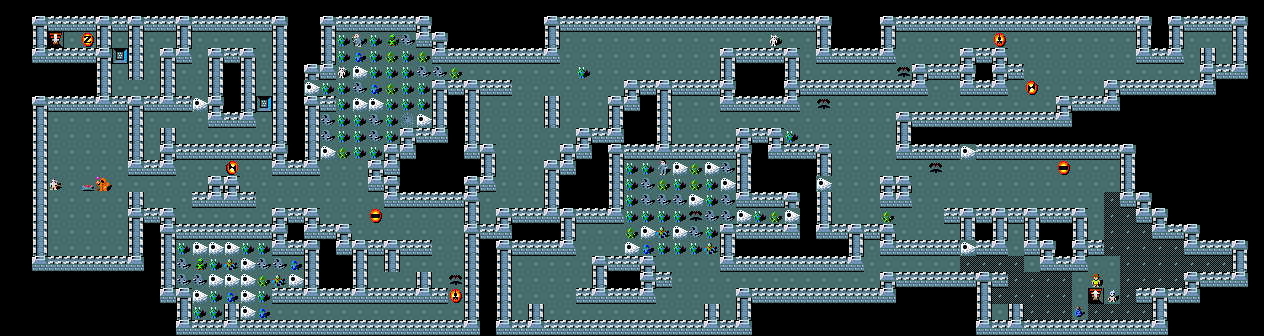

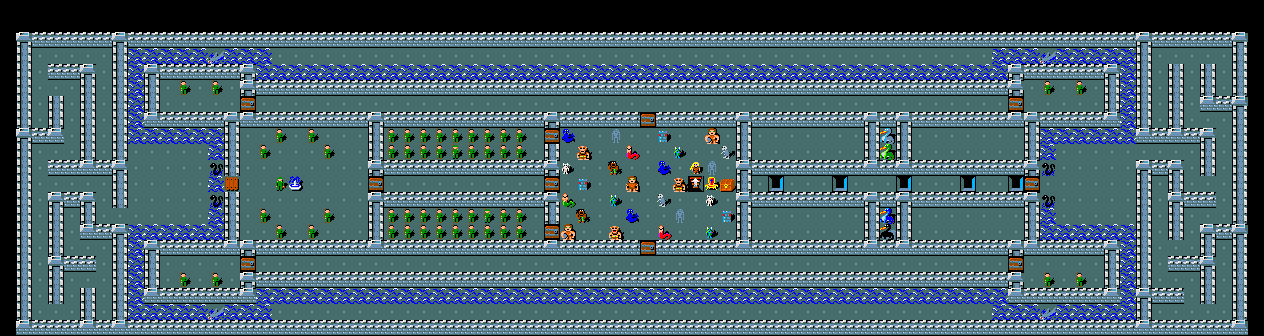

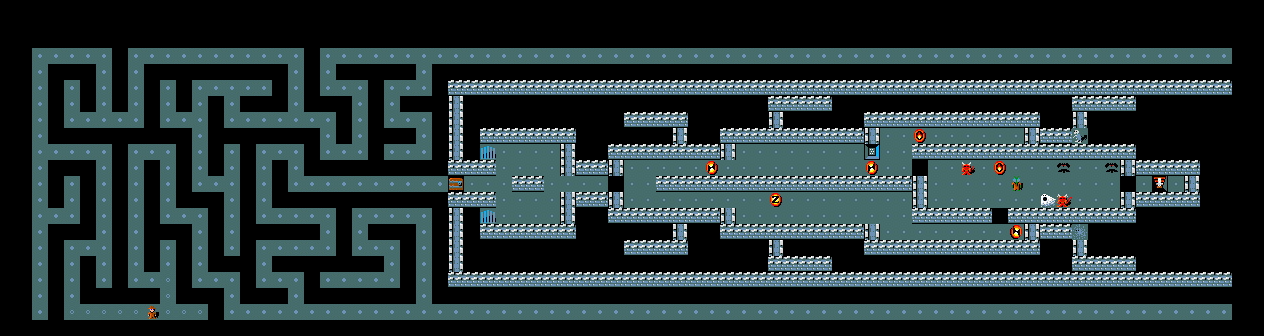

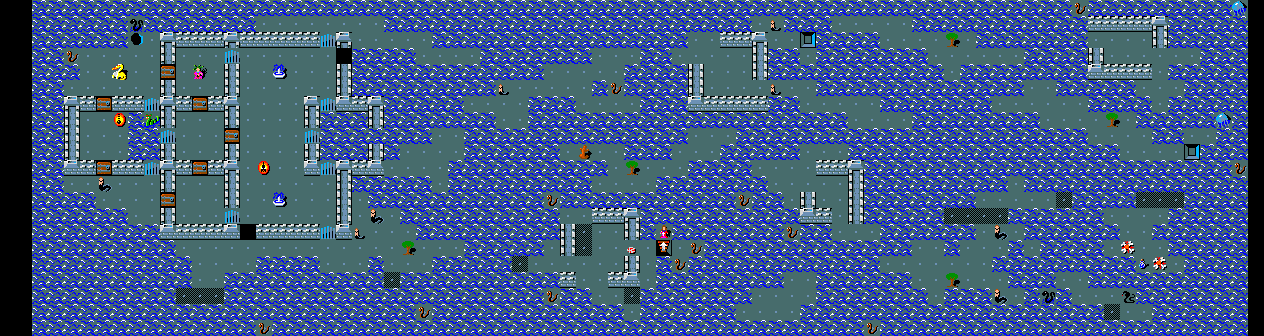

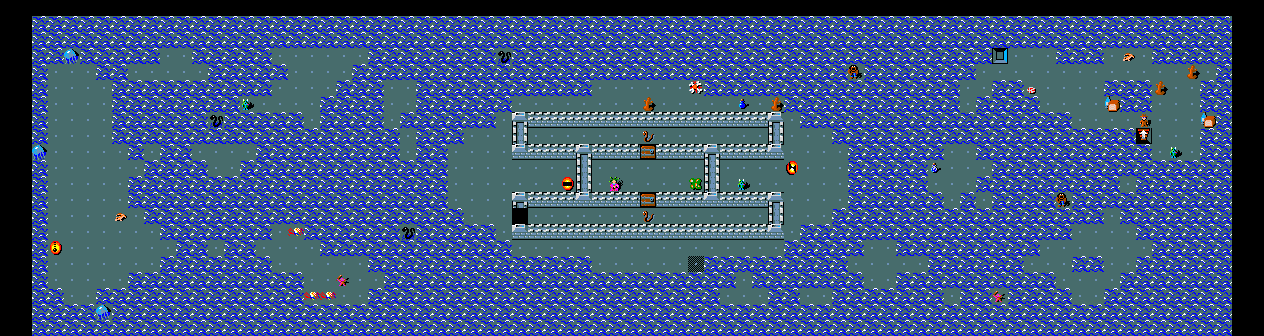

In [572]:
des_files = [des_valey, des_castle, des_Baalzebub, des_med, des_med1]

for des in des_files:
    vis_des(des)

In [573]:

def vis_des(des_name):
    class COR(MiniHackSkill):
        def __init__(self, *args, **kwargs):
            kwargs["wizard"] = True
            super().__init__(*args, des_file=des_name, **kwargs)

    observation_keys = ("glyphs", "pixel")
    env = COR(savedir=None,archivefile=None,observation_keys=observation_keys)
    obs = env.reset()

    for c in "#wizintrinsic\rt\r\r":
        obs,sds = env.env.step(ord(c))

    obs,_,_,_ =env.step(0)

    display(obs["pixel"]) #
    